#Lab 4 - Grounding DINO: Detección guiada por texto

**Objetivos**
1. Entender cómo funciona y cómo está compuesta la arquitectura de Grounding DINO.
2. Cargar modelos Grounding DINO desde la libreria de Hugging Face "transformers".
3. Ejecutar detección guiada por texto sobre imágenes.


## ¿Qué es Grounding DINO?

**Grounding DINO** es un detector *open-vocabulary* que une dos ideas:
- **DINO** (detección con transformers) para localizar boxes con gran *recall*.
- **Alineamiento texto–imagen** (similar a CLIP/contrastivo) para “aterrizar” conceptos del lenguaje natural en regiones de la imagen.

### Componentes principales
- **Backbone visual** (CNN/ViT): extrae mapas de características multi-escala de la imagen.
- **Backbone textual** (encoder de lenguaje): codifica el *prompt* (“person with red hat”, “traffic light”, etc.) en embeddings.
- **Bloques de fusión cruzada** (*cross-modal transformer*): el texto guía la selección/realce de regiones visuales relevantes mediante atención cruzada.
- **Queries guiadas por lenguaje**: en lugar de *queries* fijas, la arquitectura prioriza o crea consultas influenciadas por el texto, de modo que las regiones candidatas responden al *prompt*.
- **Cabeza de detección**: retorna boxes (x1, y1, x2, y2) y una puntuación por término o frase del *prompt* (frases predichas).

### ¿Por qué es *open-vocabulary*?
Porque no necesita una lista cerrada de clases (“dog, cat, car…”). El modelo evalúa similaridad texto–región y puede detectar conceptos no vistos si el lenguaje lo describe y la visualización lo soporta.


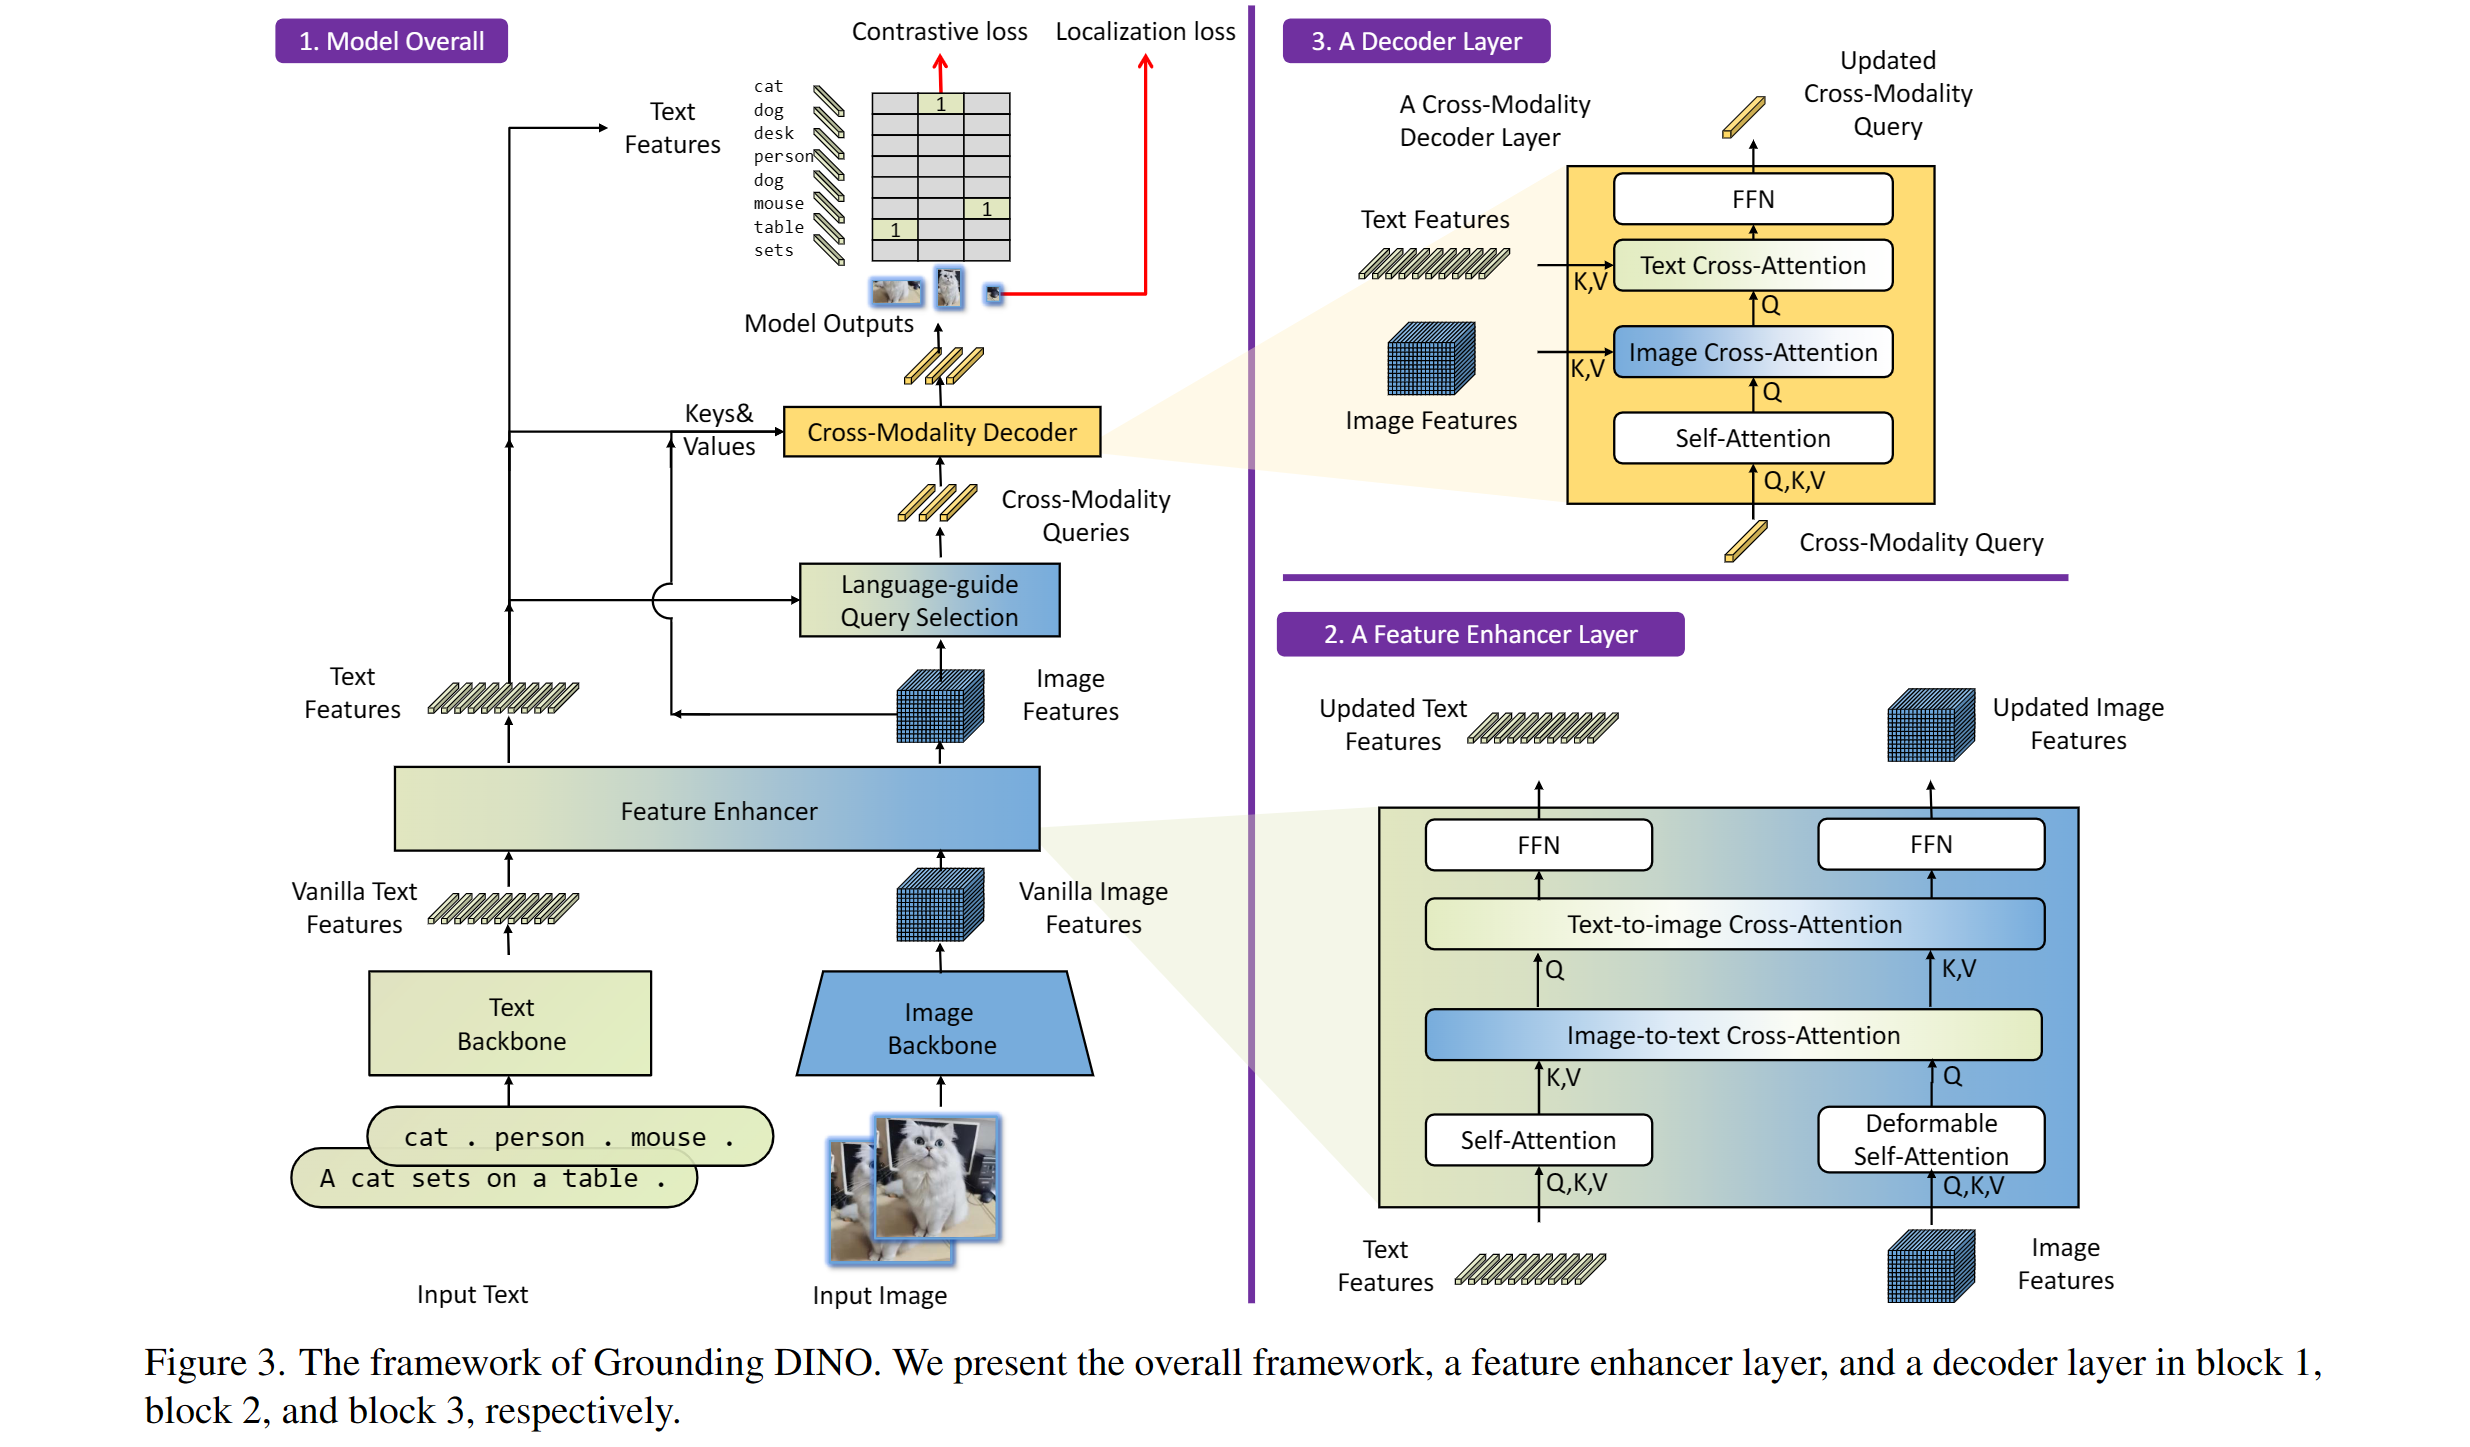


## 1) Setup e instalación


In [ ]:
!pip -q install --upgrade transformers

import warnings
warnings.filterwarnings("ignore")

import numpy as np
from pathlib import Path
from PIL import Image

import torch
import cv2
import matplotlib.pyplot as plt

from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available(), "| Device:", device)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 54.7 MB/s eta 0:00:00
Torch: 2.8.0+cu126 | CUDA: True | Device: cuda



## 2) Cargar el modelo


In [ ]:
model_id = "IDEA-Research/grounding-dino-tiny"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
model.eval()
print("Modelo cargado")

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

Modelo cargado


## 3) Inferencia con imagen subida + prompt
1. Sube una imagen.  
2. Escribe un prompt (ej.: `person . traffic light . backpack`).  
   - Usa puntos (`.`) para separar conceptos/frases; el modelo devuelve clases detectadas de las frases.
3. Ajusta umbrales si es necesario:
   - `BOX_THRESHOLD` (confianza de caja)
   - `TEXT_THRESHOLD` (confianza de frase)


In [ ]:
from google.colab import files

# 1) Subir imagen
uploaded = files.upload()
IMG_PATH = list(uploaded.keys())[0]

# 2) Cargar imagen PIL (RGB) y preparar para dibujar (BGR)
IMAGE_PIL = Image.open(IMG_PATH).convert("RGB")

IMG_NP = np.array(IMAGE_PIL)
if IMG_NP.dtype != np.uint8:
    IMG_NP = (IMG_NP * 255).astype(np.uint8) if IMG_NP.max() <= 1 else IMG_NP.astype(np.uint8)
IMG_SHAPE = IMG_NP.shape[:2]  # (H, W)

Saving mineros.jpg to mineros.jpg


In [ ]:
def run_prompt(prompt):
    prompt = prompt.split(".")
    prompt = [[x.strip() for x in prompt]]

    # Preprocesar
    inputs = processor(images=IMAGE_PIL, text=prompt, return_tensors="pt").to(device)

    # Predicción
    with torch.no_grad():
        outputs = model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD,
        target_sizes=[IMG_SHAPE]  # (H, W) de la imagen original
    )

    det = results[0]
    boxes  = det["boxes"].detach().cpu().numpy()
    scores = det["scores"].detach().cpu().numpy()
    labels = [str(x) for x in det["labels"]]

    # Copia de trabajo para dibujar
    img_bgr = np.ascontiguousarray(IMG_NP[:, :, ::-1])
    H, W = img_bgr.shape[:2]

    # Paleta por clase (simple; estable si quieres fija la seed o define un dict global)
    uniq = sorted(set(labels))
    rng = np.random.default_rng(42)
    color_map = {lab: tuple(int(c) for c in rng.integers(0, 255, 3)) for lab in uniq}

    # Dibujar
    for (x1, y1, x2, y2), sc, lab in zip(boxes, scores, labels):
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        color = color_map[lab]
        thickness = max(2, int(0.003 * max(H, W)))
        font_scale = max(0.5, 0.0005 * max(H, W))
        font = cv2.FONT_HERSHEY_SIMPLEX

        cv2.rectangle(img_bgr, (x1, y1), (x2, y2), color, thickness)

        text = f"{lab} {float(sc):.2f}"
        (tw, th), _ = cv2.getTextSize(text, font, font_scale, thickness)
        x_bg2 = min(x1 + tw + 6, W - 1)
        y_bg2 = min(y1 + th + 6, H - 1)
        cv2.rectangle(img_bgr, (x1, y1), (x_bg2, y_bg2), color, -1)
        cv2.putText(img_bgr, text, (x1 + 3, y1 + th + 1), font,
                    font_scale, (255, 255, 255), max(1, thickness // 2), cv2.LINE_AA)

    # Mostrar
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb); plt.axis('off')
    plt.title(f"Prompt: {prompt}")
    plt.show()

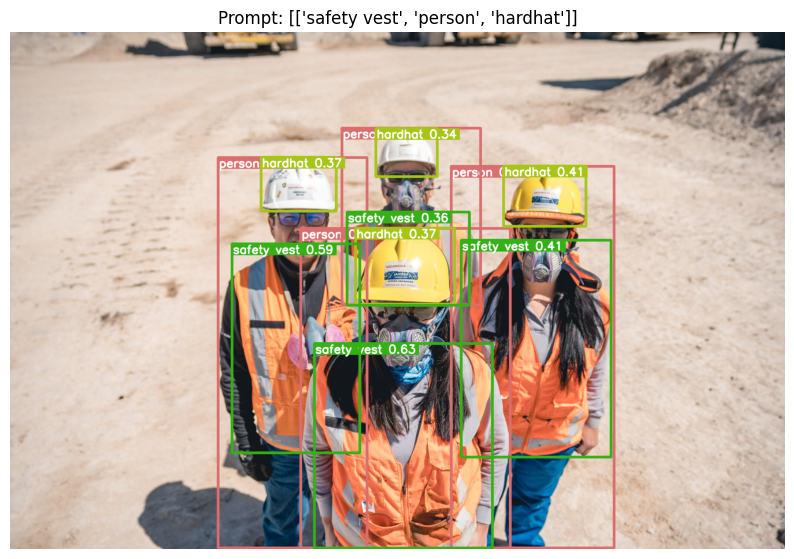

In [ ]:
BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.2
run_prompt("safety vest. person. hardhat")

## 4) Inferencia en DocExplore

In [ ]:
!wget "https://www.dropbox.com/scl/fi/o7e71pulibvyoam0vp1ls/000019.jpg?rlkey=5x7c4yypohamxid5cp2pvvr0l&st=ufelf3l2&dl=0" -O page1.jpg

IMAGE_PIL = Image.open("page1.jpg").convert("RGB")
IMG_NP = np.array(IMAGE_PIL)
if IMG_NP.dtype != np.uint8:
    IMG_NP = (IMG_NP * 255).astype(np.uint8) if IMG_NP.max() <= 1 else IMG_NP.astype(np.uint8)
IMG_SHAPE = IMG_NP.shape[:2]  # (H, W)

--2025-10-07 20:54:03--  https://www.dropbox.com/scl/fi/o7e71pulibvyoam0vp1ls/000019.jpg?rlkey=5x7c4yypohamxid5cp2pvvr0l&st=ufelf3l2&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc1586b3a81f7f8f713c4baf132.dl.dropboxusercontent.com/cd/0/inline/Cyy9hLC19LkfddWoj6qTeZ1PXWSt6cf1PHKhOA2ZhbnGSMdZV6Tmglf7FcWae6F7j4AAHagqXWOIs66pY5pgAXgbrI4Dml1umsPIxWJXGq-7s4YCuU72MQqTY3oBKOosdHBtXcCnftKGhAL_M5nn7-g3/file# [following]
--2025-10-07 20:54:03--  https://ucc1586b3a81f7f8f713c4baf132.dl.dropboxusercontent.com/cd/0/inline/Cyy9hLC19LkfddWoj6qTeZ1PXWSt6cf1PHKhOA2ZhbnGSMdZV6Tmglf7FcWae6F7j4AAHagqXWOIs66pY5pgAXgbrI4Dml1umsPIxWJXGq-7s4YCuU72MQqTY3oBKOosdHBtXcCnftKGhAL_M5nn7-g3/file
Resolving ucc1586b3a81f7f8f713c4baf132.dl.dropboxusercontent.com (ucc1586b3a81f7f8f713c4baf132.dl.dropboxusercontent.com)... 16

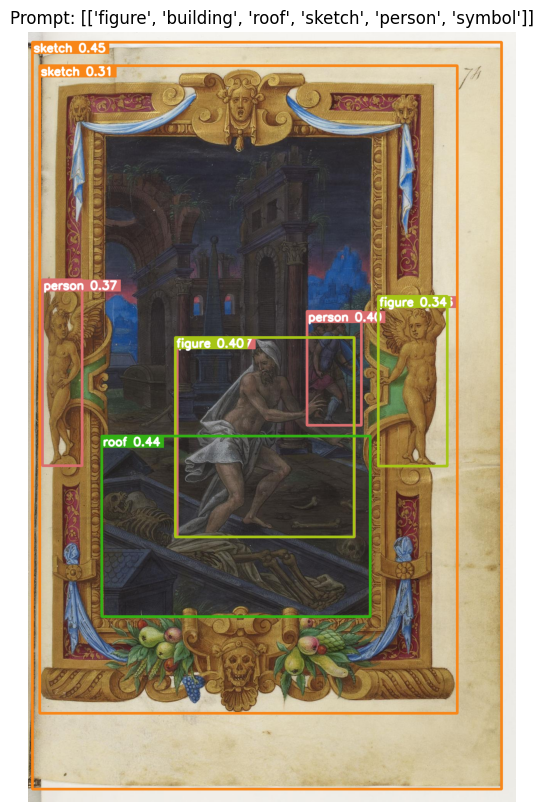

In [ ]:
BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.2
run_prompt("figure. building. roof. sketch. person. symbol")